# **Mailchimp Campaign Analysis & Hypothesis Testing**

### **Objective**
The purpose of this notebook is to perform the primary data analysis for the capstone project. The goal is to prepare the staged Mailchimp data for statistical testing and then execute the tests required to evaluate Hypothesis Set 1[cite: 101, 102]. The central aim is to analyze the processed data to identify key characteristics of high-performing email campaigns[cite: 90].

### **Notebook Outline**
* **Setup:** Import necessary Python libraries and configure the environment.
* **Data Loading:** Execute a SQL query using the Python client to create the unified analytical dataset in BigQuery and load the resulting table into a pandas DataFrame.
* **Exploratory Data Analysis (EDA):** Perform initial data cleaning, check distributions, and create visualizations to understand the relationships between variables.
* **Hypothesis 1 Testing: Campaign Characteristics vs. Effectiveness**[cite: 50]:
    * Conduct Independent Samples T-tests to compare effectiveness metrics between binary groups[cite: 51].
    * Conduct ANOVA to compare effectiveness metrics across multiple groups[cite: 55].
    * Build and interpret a Multiple Linear Regression model to assess the combined impact of all features on campaign open rates[cite: 59, 60].
* **Interpretation of Findings:** Summarize the statistical results and determine whether to reject the null hypothesis for Hypothesis Set 1.

In [1]:
# Core libraries for data manipulation and numerics
import pandas as pd
import numpy as np

# Google Cloud library to interact with BigQuery
from google.cloud import bigquery

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for statistical testing, as per the analysis plan [cite: 36, 49]
from scipy import stats  # For T-tests and ANOVA [cite: 51, 55]
import statsmodels.api as sm
from statsmodels.formula.api import ols # For Multiple Linear Regression [cite: 59]

# --- Notebook Settings ---
# Setting plot styles for aesthetics
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
# Configure pandas to display all columns
pd.set_option('display.max_columns', None)

print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# This is the corrected code block using the exact column names from your schemas.

# 1. Instantiate the BigQuery Client
project_id = "mis581-capstone-data"  # <-- Make sure this is still your correct Project ID
client = bigquery.Client(project=project_id)
print(f"BigQuery client created for project: {client.project}")

# 2. Define the revised SQL query
sql_create_analytics_table = f"""
CREATE OR REPLACE TABLE `{project_id}.processed_data.peer2_campaign_analytics` AS
SELECT
  -- Columns from the 'campaigns' table (peer2_campaigns_stg)
  campaigns.campaign_id,
  campaigns.subject_line,
  campaigns.send_time,

  -- Corrected columns from the 'reports' table (peer2_reports_stg)
  reports.opens_total,
  reports.clicks_total,
  reports.unsubscribed_total,

  -- Use the pre-calculated open_rate directly
  reports.open_rate,

  -- Engineered features
  CHAR_LENGTH(campaigns.subject_line) AS subject_line_length,
  STRPOS(LOWER(campaigns.subject_line), '*|fname|*') > 0 AS has_personalization,
  STRPOS(campaigns.subject_line, '?') > 0 AS has_question,
  REGEXP_CONTAINS(campaigns.subject_line, r'\\d') AS has_number,
  REGEXP_CONTAINS(LOWER(campaigns.subject_line), r'sale|free|% off|discount|save') AS has_promo_word,
  EXTRACT(DAYOFWEEK FROM campaigns.send_time) AS send_day_of_week,
  EXTRACT(HOUR FROM campaigns.send_time) AS send_hour_of_day,

  -- Calculate click_through_open_rate using the correct column names
  SAFE_DIVIDE(reports.clicks_total, reports.opens_total) AS click_through_open_rate

FROM
  `{project_id}.staging_data.peer2_campaigns_stg` AS campaigns
INNER JOIN
  `{project_id}.staging_data.peer2_reports_stg` AS reports ON campaigns.campaign_id = reports.campaign_id;
"""

# 3. Execute the query job
print("Running query to create or replace the analytics table in BigQuery...")
create_job = client.query(sql_create_analytics_table)
create_job.result()  # Wait for the job to complete
print("Table `processed_data.peer2_campaign_analytics` created successfully.")


# 4. Load the data from the new table into a pandas DataFrame
print("Loading data from the new BigQuery table into a pandas DataFrame...")
table_id = f"{project_id}.processed_data.peer2_campaign_analytics"
sql_load_data = f"SELECT * FROM `{table_id}`"

# Run the query and convert to a DataFrame
campaign_df = client.query(sql_load_data).to_dataframe()
print("Data loaded successfully.")

# 5. Verify the DataFrame
print(f"Shape of the DataFrame: {campaign_df.shape}")
print("First 5 rows of the campaign data:")
display(campaign_df.head())

print("\nDataFrame Info:")
campaign_df.info()

BigQuery client created for project: mis581-capstone-data
Running query to create or replace the analytics table in BigQuery...
Table `processed_data.peer2_campaign_analytics` created successfully.
Loading data from the new BigQuery table into a pandas DataFrame...
Data loaded successfully.
Shape of the DataFrame: (2160, 15)
First 5 rows of the campaign data:


,campaign_id,subject_line,send_time,opens_total,clicks_total,unsubscribed_total,open_rate,subject_line_length,has_personalization,has_question,has_number,has_promo_word,send_day_of_week,send_hour_of_day,click_through_open_rate
0,2bf54a0292,None,NaT,0,0,0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1,db8c2fc385,None,NaT,0,0,0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
2,490ccd0db3,None,NaT,0,0,0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
3,9d725c0aa1,None,NaT,0,0,0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
4,4f02de04fc,None,NaT,0,0,0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   campaign_id              2160 non-null   object             
 1   subject_line             2133 non-null   object             
 2   send_time                1945 non-null   datetime64[us, UTC]
 3   opens_total              2160 non-null   Int64              
 4   clicks_total             2160 non-null   Int64              
 5   unsubscribed_total       2160 non-null   Int64              
 6   open_rate                2160 non-null   float64            
 7   subject_line_length      2133 non-null   Int64              
 8   has_personalization      2133 non-null   boolean            
 9   has_question             2133 non-null   boolean            
 10  has_number               2133 non-null   boolean            
 11  has_promo_wor

In [3]:
# --- Data Cleaning Step (Revised to avoid FutureWarning) ---

print(f"Original shape of DataFrame: {campaign_df.shape}")

# 1. Handle missing send_time and subject_line
# Campaigns without a send_time or subject_line cannot be analyzed for performance.
# We will remove these rows.
campaign_df.dropna(subset=['send_time', 'subject_line'], inplace=True)
print(f"Shape after dropping rows with null send_time/subject_line: {campaign_df.shape}")

# 2. Handle missing click_through_open_rate (using the recommended syntax)
# A null value here means the campaign had 0 opens. It's correct to treat the rate as 0.
campaign_df['click_through_open_rate'] = campaign_df['click_through_open_rate'].fillna(0)
print("Nulls in 'click_through_open_rate' filled with 0.")

# --- Verification Step ---
# Verify that the cleaning process worked by checking for nulls again.
print("\nVerifying cleaning process by checking for nulls in key columns:")
print(f"Nulls in send_time: {campaign_df['send_time'].isnull().sum()}")
print(f"Nulls in click_through_open_rate: {campaign_df['click_through_open_rate'].isnull().sum()}")
print(f"Nulls in subject_line: {campaign_df['subject_line'].isnull().sum()}")

print("\nUpdated DataFrame Info:")
campaign_df.info()

Original shape of DataFrame: (2160, 15)
Shape after dropping rows with null send_time/subject_line: (1945, 15)
Nulls in 'click_through_open_rate' filled with 0.

Verifying cleaning process by checking for nulls in key columns:
Nulls in send_time: 0
Nulls in click_through_open_rate: 0
Nulls in subject_line: 0

Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1945 entries, 215 to 2159
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   campaign_id              1945 non-null   object             
 1   subject_line             1945 non-null   object             
 2   send_time                1945 non-null   datetime64[us, UTC]
 3   opens_total              1945 non-null   Int64              
 4   clicks_total             1945 non-null   Int64              
 5   unsubscribed_total       1945 non-null   Int64              
 6   open_rate                194

In [4]:
# Display summary statistics for numerical columns
campaign_df.describe()

,opens_total,clicks_total,unsubscribed_total,open_rate,subject_line_length,send_day_of_week,send_hour_of_day,click_through_open_rate
count,1945.0,1945.0,1945.0,1945.000000,1945.0,1945.0,1945.0,1945.000000
mean,459.05964,15.091517,1.597943,0.591347,50.468895,3.877635,14.667866,0.409687
std,565.875448,26.784767,3.209553,0.343947,15.263468,1.63502,4.054505,0.985610
min,0.0,0.0,0.0,0.000000,10.0,1.0,0.0,0.000000
25%,4.0,2.0,0.0,0.316492,40.0,2.0,12.0,0.008499
50%,203.0,6.0,0.0,0.523810,50.0,4.0,15.0,0.032653
75%,1067.0,19.0,2.0,1.000000,62.0,5.0,18.0,0.370130
max,2158.0,368.0,70.0,1.000000,96.0,7.0,23.0,14.000000


In [5]:
# Analyze the distribution of the 'has_personalization' feature
print("Distribution of 'has_personalization':")
print(campaign_df['has_personalization'].value_counts(normalize=True))

print("\n-----------------------------------------\n")

# Analyze the distribution of the 'has_question' feature
print("Distribution of 'has_question':")
print(campaign_df['has_question'].value_counts(normalize=True))

# You can repeat this for has_number and has_promo_word

Distribution of 'has_personalization':
has_personalization
False    1.0
Name: proportion, dtype: Float64

-----------------------------------------

Distribution of 'has_question':
has_question
False    0.971208
True     0.028792
Name: proportion, dtype: Float64


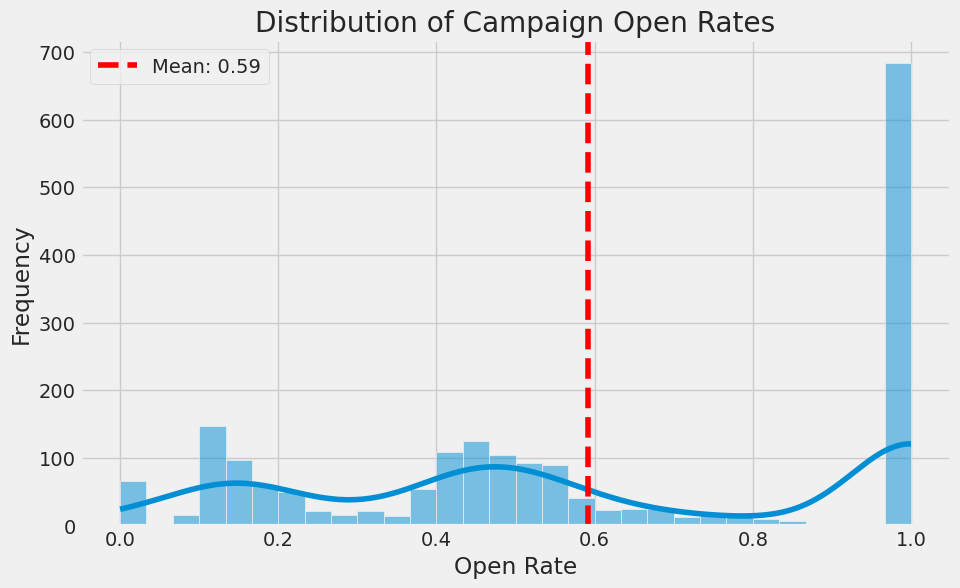

In [6]:
# Set up the plot style
plt.figure(figsize=(10, 6))
sns.histplot(campaign_df['open_rate'], kde=True, bins=30)

# Add a vertical line for the mean open rate
plt.axvline(campaign_df['open_rate'].mean(), color='red', linestyle='--', label=f"Mean: {campaign_df['open_rate'].mean():.2f}")

# Add titles and labels
plt.title('Distribution of Campaign Open Rates')
plt.xlabel('Open Rate')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
# Filter the DataFrame for campaigns with an open rate of 95% or higher
high_open_rate_campaigns = campaign_df[campaign_df['open_rate'] >= 0.95]

# Display relevant columns to inspect them
print(f"Found {len(high_open_rate_campaigns)} campaigns with an open rate of 95% or higher.")
print("Inspecting these campaigns:")

# Display a sample of these campaigns, focusing on key columns
# Using .head(20) to see a good sample
display(high_open_rate_campaigns[['subject_line', 'open_rate', 'opens_total', 'clicks_total']].head(20))

Found 684 campaigns with an open rate of 95% or higher.
Inspecting these campaigns:


,subject_line,open_rate,opens_total,clicks_total
227,IMPORTANT: Private Lessons Schedule and Regist...,1.0,4,2
229,IMPORTANT: Private Lessons Schedule and Regist...,1.0,3,4
230,IMPORTANT: Private Lessons Schedule and Regist...,1.0,2,0
232,IMPORTANT: Private Lessons Schedule and Regist...,1.0,3,6
233,IMPORTANT: Private Lessons Schedule and Regist...,1.0,1,2
274,Welcome to Homeschool Classes at Naptown Sings...,1.0,61,15
276,Welcome: Private Lessons Registration Instruct...,1.0,2,3
279,Welcome: Private Lessons Registration Instruct...,1.0,2,5
280,Welcome: Private Lessons Registration Instruct...,1.0,2,2
281,Welcome: Private Lessons Registration Instruct...,1.0,3,2


In [8]:
# We already have the DataFrame 'high_open_rate_campaigns' from the previous step.
# Let's get the list of campaign IDs to investigate.
campaign_ids_to_check = high_open_rate_campaigns['campaign_id'].tolist()

# Prepare the list of IDs for use in a SQL IN clause
# This formats the Python list into a string like "'id1', 'id2', 'id3'"
formatted_campaign_ids = ", ".join(f"'{id}'" for id in campaign_ids_to_check)

# Define the SQL query to get the recipients for these specific campaigns
sql_get_recipients = f"""
SELECT
  c.campaign_id,
  c.subject_line,
  m.email_address,
  m.status AS member_status,
  m.list_id
FROM
  `{project_id}.staging_data.peer2_campaigns_stg` AS c
JOIN
  `{project_id}.staging_data.peer2_members_stg` AS m
ON
  c.recipients_list_id = m.list_id
WHERE
  c.campaign_id IN ({formatted_campaign_ids})
ORDER BY
  c.campaign_id, m.email_address;
"""

# Execute the query
print("Querying BigQuery to find recipient lists for high-open-rate campaigns...")
recipients_df = client.query(sql_get_recipients).to_dataframe()

# Display the results
print(f"Found {len(recipients_df)} total members on the lists for these campaigns.")
print("Displaying recipients for each campaign:")
display(recipients_df)

Querying BigQuery to find recipient lists for high-open-rate campaigns...
Found 29542 total members on the lists for these campaigns.
Displaying recipients for each campaign:


,campaign_id,subject_line,email_address,member_status,list_id
0,0674e5315d,IMPORTANT: School Year 2023-2024 Private Lesso...,Ahprost@hotmail.com,subscribed,6fa6cd3238
1,0674e5315d,IMPORTANT: School Year 2023-2024 Private Lesso...,Graham.ashley8@gmail.com,subscribed,6fa6cd3238
2,0674e5315d,IMPORTANT: School Year 2023-2024 Private Lesso...,Jeanine@audiencefocus.com,subscribed,6fa6cd3238
3,0674e5315d,IMPORTANT: School Year 2023-2024 Private Lesso...,Kathleen.Prendergast@umm.edu,subscribed,6fa6cd3238
4,0674e5315d,IMPORTANT: School Year 2023-2024 Private Lesso...,Mckenna@councilbaradel.com,subscribed,6fa6cd3238
...,...,...,...,...,...
29537,ff846d370f,IMPORTANT: School Year 2023-2024 Private Lesso...,vocalcoachmb@yahoo.com,subscribed,6fa6cd3238
29538,ff846d370f,IMPORTANT: School Year 2023-2024 Private Lesso...,wenholland1@gmail.com,subscribed,6fa6cd3238
29539,ff846d370f,IMPORTANT: School Year 2023-2024 Private Lesso...,winn0331@gmail.com,subscribed,6fa6cd3238
29540,ff846d370f,IMPORTANT: School Year 2023-2024 Private Lesso...,winnie1492@yahoo.com,subscribed,6fa6cd3238


Shape of DataFrame before filtering: (1945, 15)
Shape of DataFrame after filtering out campaigns with < 10 opens: (1258, 15)


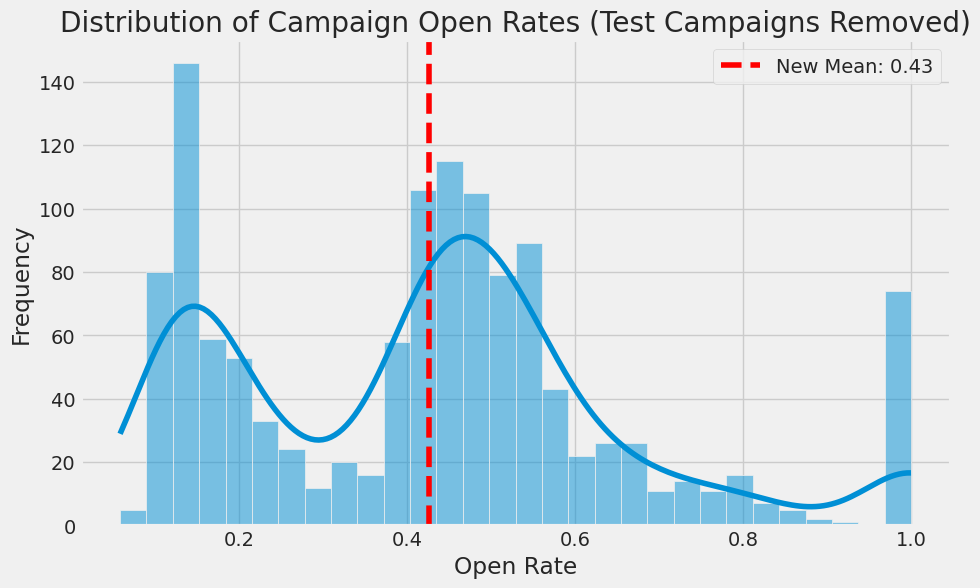

In [9]:
# --- Filter Out Test/Micro-Campaigns ---

print(f"Shape of DataFrame before filtering: {campaign_df.shape}")

# Define a threshold for what constitutes a "real" campaign
# We will remove campaigns with fewer than 10 total opens
min_opens_threshold = 10

# Apply the filter
campaign_df = campaign_df[campaign_df['opens_total'] >= min_opens_threshold]

print(f"Shape of DataFrame after filtering out campaigns with < {min_opens_threshold} opens: {campaign_df.shape}")

# --- Re-examine the Open Rate Distribution ---

# Now that test campaigns are removed, let's look at the histogram again
plt.figure(figsize=(10, 6))
sns.histplot(campaign_df['open_rate'], kde=True, bins=30)

# Add a vertical line for the new mean open rate
plt.axvline(campaign_df['open_rate'].mean(), color='red', linestyle='--', label=f"New Mean: {campaign_df['open_rate'].mean():.2f}")

plt.title('Distribution of Campaign Open Rates (Test Campaigns Removed)')
plt.xlabel('Open Rate')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [17]:
# --- Create 'send_day_name' Column for Visualization ---

# Define a mapping from the numerical day of the week to a name
# Note: BigQuery's DAYOFWEEK returns 1 for Sunday and 7 for Saturday.
day_map = {
    1: 'Sun',
    2: 'Mon',
    3: 'Tue',
    4: 'Wed',
    5: 'Thu',
    6: 'Fri',
    7: 'Sat'
}

# Create the new 'send_day_name' column by applying the map
campaign_df['send_day_name'] = campaign_df['send_day_of_week'].map(day_map)

print("Created 'send_day_name' column successfully.")
print("\nValue counts for the new column:")
print(campaign_df['send_day_name'].value_counts())

Created 'send_day_name' column successfully.

Value counts for the new column:
send_day_name
Mon    291
Tue    212
Fri    212
Wed    204
Thu    183
Sat     97
Sun     59
Name: count, dtype: int64


In [18]:
# Filter the current DataFrame for campaigns with a very high open rate
remaining_high_performers = campaign_df[campaign_df['open_rate'] >= 0.95]

print(f"Found {len(remaining_high_performers)} campaigns with >= 10 opens and an open rate of 95% or higher.")
print("Inspecting a sample of these campaigns:")

# Display a sample, focusing on subject line and total opens
display(remaining_high_performers[['subject_line', 'open_rate', 'opens_total']].head(20))

Found 74 campaigns with >= 10 opens and an open rate of 95% or higher.
Inspecting a sample of these campaigns:


,subject_line,open_rate,opens_total
274,Welcome to Homeschool Classes at Naptown Sings...,1.0,61
347,Glee Club Practice Tracks Are Online,1.0,36
364,IMPORTANT: Fall 2022 Private Lessons Registrat...,1.0,30
370,IMPORTANT: Fall 2022 Private Lessons Registrat...,1.0,12
400,IMPORTANT: Outreach Private Lessons Schedule a...,1.0,23
402,IMPORTANT: Private Lessons Registration Instru...,1.0,20
406,IMPORTANT: Private Lessons Registration Instru...,1.0,10
420,IMPORTANT: Private Lessons Registration Instru...,1.0,80
424,IMPORTANT: Private Lessons Registration Instru...,1.0,11
440,IMPORTANT: Private Lessons Schedule and Regist...,1.0,17


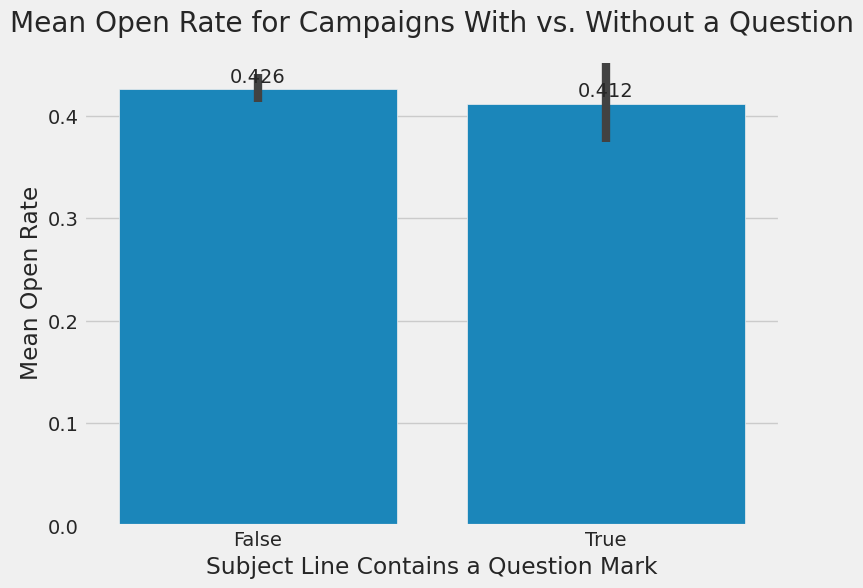

In [19]:
# Create a bar plot to compare the mean open_rate for the 'has_question' feature
plt.figure(figsize=(8, 6))
sns.barplot(x='has_question', y='open_rate', data=campaign_df)

# Add titles and labels
plt.title('Mean Open Rate for Campaigns With vs. Without a Question')
plt.xlabel('Subject Line Contains a Question Mark')
plt.ylabel('Mean Open Rate')

# Add annotations to the bars to show the exact mean values
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.3f}',  # Format to 3 decimal places
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, 9), 
                       textcoords='offset points')

plt.show()

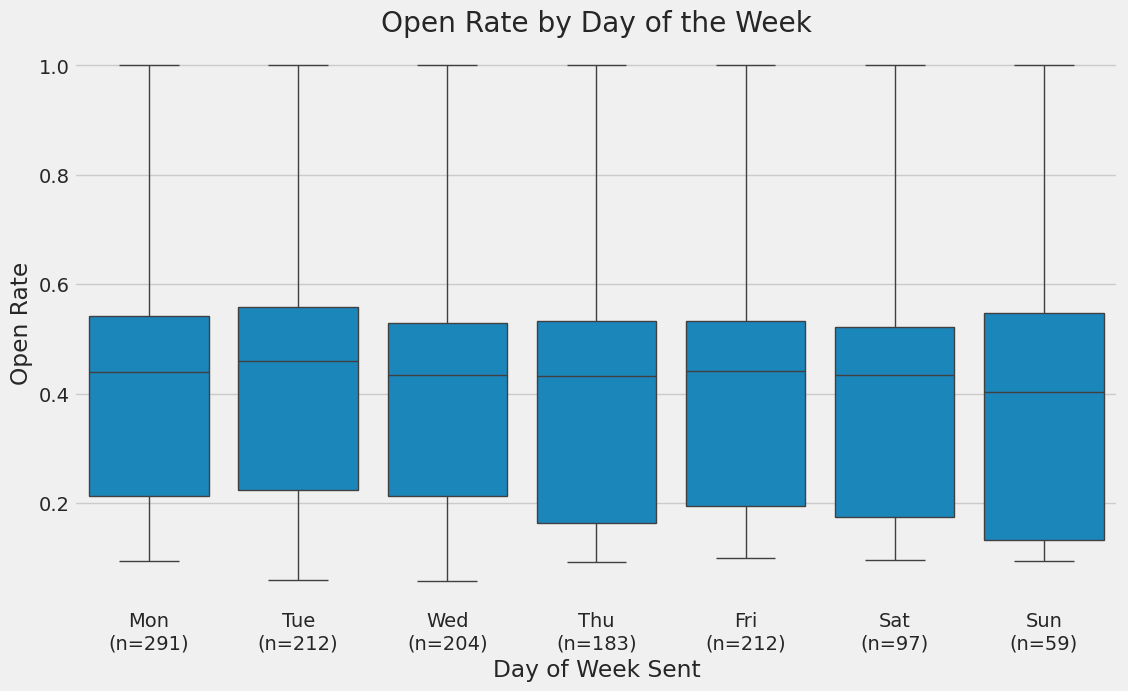

In [20]:
# --- Updated Box Plot for 'Day of the Week' with Segment Sizes (Corrected) ---

# 1. Calculate counts
day_counts = campaign_df['send_day_name'].value_counts()
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
new_labels = [f'{day}\n(n={day_counts.get(day, 0)})' for day in day_order]

# 2. Visual Analysis: Box Plot
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='send_day_name', y='open_rate', data=campaign_df, order=day_order)
plt.title('Open Rate by Day of the Week')
plt.xlabel('Day of Week Sent')
plt.ylabel('Open Rate')

# 3. Set Ticks and Labels (The Corrected Part)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(new_labels)

plt.show()

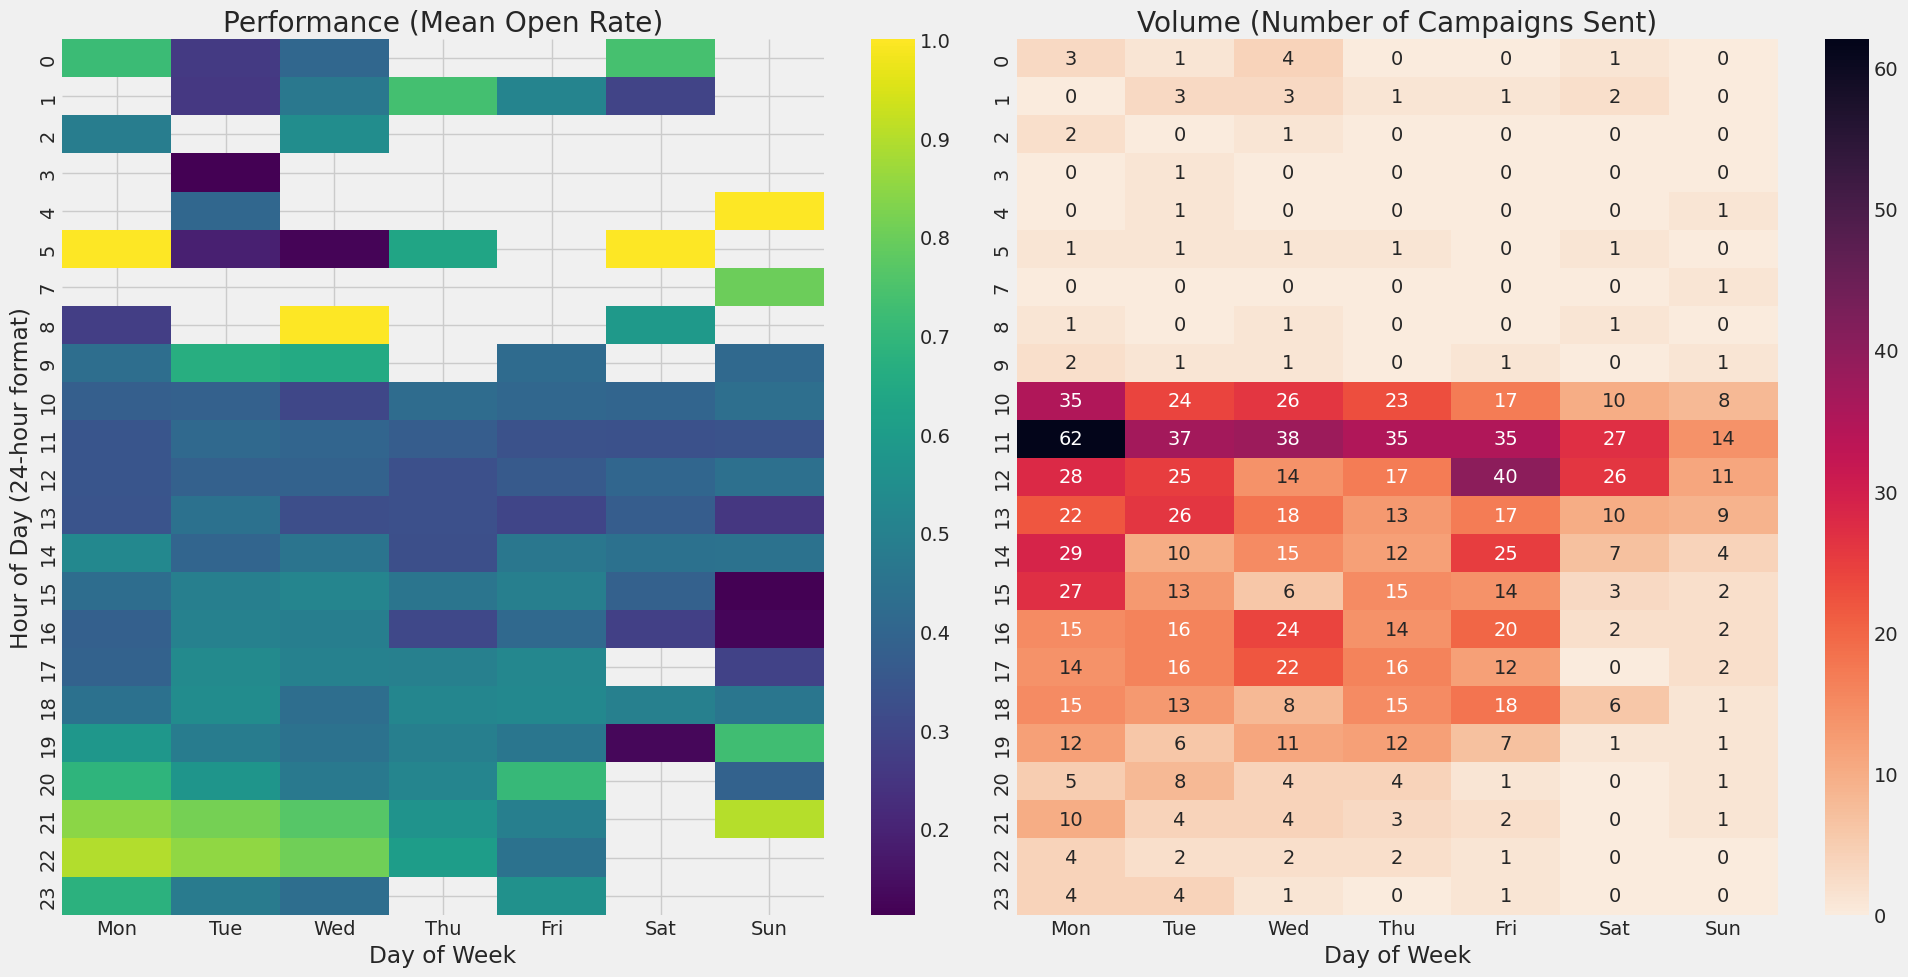

In [21]:
# --- Create a side-by-side Heatmap for Performance and Volume ---

# 1. Prepare the data for BOTH heatmaps
# This first one is for performance (mean open rate), which we've done before
performance_data = campaign_df.groupby(['send_hour_of_day', 'send_day_name'])['open_rate'].mean().unstack(level='send_day_name')

# This second one is for volume (count of campaigns)
volume_data = campaign_df.groupby(['send_hour_of_day', 'send_day_name']).size().unstack(level='send_day_name')

# Reorder columns for both datasets to ensure they match
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
performance_data = performance_data.reindex(columns=day_order)
volume_data = volume_data.reindex(columns=day_order)

# 2. Create the figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10)) # 1 row, 2 columns

# 3. Plot the Performance Heatmap (on the left)
sns.heatmap(performance_data, cmap='viridis', ax=ax1)
ax1.set_title('Performance (Mean Open Rate)')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Hour of Day (24-hour format)')

# 4. Plot the Volume Heatmap (on the right)
# We fill NaN with 0 for cells where no campaigns were sent
# annot=True displays the numbers; fmt='g' prevents decimals (e.g., 25.0)
sns.heatmap(volume_data.fillna(0), cmap='rocket_r', annot=True, fmt='g', ax=ax2)
ax2.set_title('Volume (Number of Campaigns Sent)')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('') # Hide y-label for cleaner look

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [22]:
from scipy.stats import ttest_ind

# --- Independent Samples T-Test for 'has_question' ---

# Create two separate groups based on the 'has_question' column
group_with_question = campaign_df[campaign_df['has_question'] == True]['open_rate']
group_without_question = campaign_df[campaign_df['has_question'] == False]['open_rate']

# Perform the t-test
# We use equal_var=False because the group sizes are very different
# nan_policy='omit' is good practice to handle any unexpected missing values
t_stat, p_value = ttest_ind(group_with_question, group_without_question, equal_var=False, nan_policy='omit')

# Print the results in a clear format
print(f"T-test results for 'has_question' vs. Open Rate:")
print("-------------------------------------------------")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the p-value
alpha = 0.05  # Standard significance level
if p_value < alpha:
    print(f"\nConclusion: The p-value ({p_value:.4f}) is less than {alpha}.")
    print("We reject the null hypothesis. There is a statistically significant difference in open rates.")
else:
    print(f"\nConclusion: The p-value ({p_value:.4f}) is greater than {alpha}.")
    print("We fail to reject the null hypothesis. There is no statistically significant difference in open rates.")

T-test results for 'has_question' vs. Open Rate:
-------------------------------------------------
T-statistic: -0.6425
P-value: 0.5227

Conclusion: The p-value (0.5227) is greater than 0.05.
We fail to reject the null hypothesis. There is no statistically significant difference in open rates.


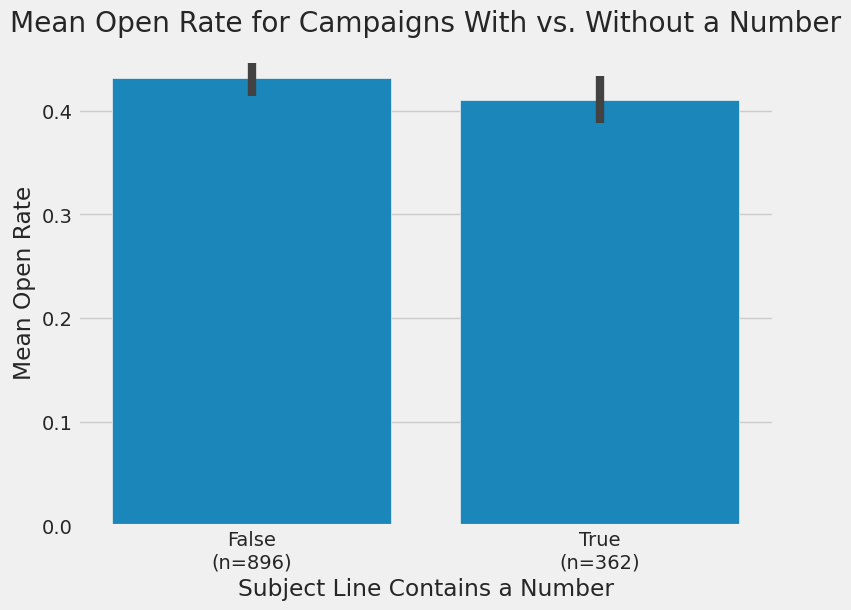

T-test results for 'has_number' vs. Open Rate:
-------------------------------------------------
T-statistic: -1.5066
P-value: 0.1324

Conclusion: The p-value is greater than 0.05. We fail to reject the null hypothesis.


In [23]:
# --- Analysis for 'has_number' with Segment Sizes (Corrected) ---

# 1. Calculate segment sizes
number_counts = campaign_df['has_number'].value_counts()

# 2. Visual Analysis: Bar Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='has_number', y='open_rate', data=campaign_df)
plt.title('Mean Open Rate for Campaigns With vs. Without a Number')
plt.ylabel('Mean Open Rate')
ax.set_xlabel('Subject Line Contains a Number')

# 3. Set Ticks and Labels (The Corrected Part)
ax.set_xticks(ax.get_xticks())
if True in number_counts.index and False in number_counts.index:
    ax.set_xticklabels([f'False\n(n={number_counts[False]})', f'True\n(n={number_counts[True]})'])

plt.show()

# (The t-test code below remains the same)
# ...

# 3. Statistical Test: Independent Samples T-test
group_with_number = campaign_df[campaign_df['has_number'] == True]['open_rate']
group_without_number = campaign_df[campaign_df['has_number'] == False]['open_rate']

if not group_with_number.empty:
    t_stat, p_value = ttest_ind(group_with_number, group_without_number, equal_var=False, nan_policy='omit')

    print(f"T-test results for 'has_number' vs. Open Rate:")
    print("-------------------------------------------------")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("\nConclusion: The p-value is less than 0.05. We reject the null hypothesis.")
    else:
        print("\nConclusion: The p-value is greater than 0.05. We fail to reject the null hypothesis.")
else:
    print("No campaigns with numbers found. T-test cannot be performed.")

/var/tmp/ipykernel_6191/1133000786.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'False\n(n={promo_counts[False]})', f'True\n(n={promo_counts[True]})'])


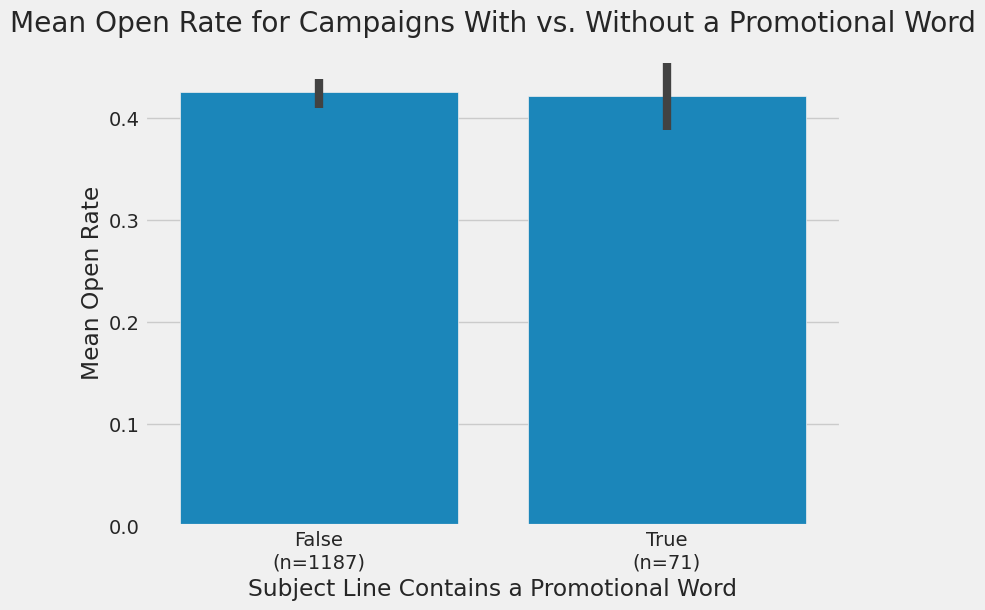

T-test results for 'has_promo_word' vs. Open Rate:
-------------------------------------------------
T-statistic: -0.2171
P-value: 0.8286

Conclusion: The p-value is greater than 0.05. We fail to reject the null hypothesis.


In [24]:
# --- Analysis for 'has_promo_word' with Segment Sizes ---

# 1. Calculate the segment sizes (counts) for the 'has_promo_word' feature
promo_counts = campaign_df['has_promo_word'].value_counts()

# 2. Visual Analysis: Bar Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='has_promo_word', y='open_rate', data=campaign_df)
plt.title('Mean Open Rate for Campaigns With vs. Without a Promotional Word')
plt.ylabel('Mean Open Rate')

# Create new labels with counts and apply them
ax.set_xlabel('Subject Line Contains a Promotional Word')
ax.set_xticklabels([f'False\n(n={promo_counts[False]})', f'True\n(n={promo_counts[True]})'])

plt.show()

# 3. Statistical Test: Independent Samples T-test
group_with_promo = campaign_df[campaign_df['has_promo_word'] == True]['open_rate']
group_without_promo = campaign_df[campaign_df['has_promo_word'] == False]['open_rate']

if not group_with_promo.empty:
    t_stat, p_value = ttest_ind(group_with_promo, group_without_promo, equal_var=False, nan_policy='omit')

    print(f"T-test results for 'has_promo_word' vs. Open Rate:")
    print("-------------------------------------------------")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("\nConclusion: The p-value is less than 0.05. We reject the null hypothesis.")
    else:
        print("\nConclusion: The p-value is greater than 0.05. We fail to reject the null hypothesis.")
else:
    print("No campaigns with promotional words found. T-test cannot be performed.")

In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- ANOVA Test for 'send_day_name' vs. Open Rate (Corrected) ---

# The formula uses the 'send_day_name' column to avoid the previous data type error.
model = ols('open_rate ~ C(send_day_name)', data=campaign_df).fit()

# [cite_start]Perform the ANOVA test on the fitted model [cite: 55]
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print("ANOVA results for 'send_day_name' vs. Open Rate:")
print("-------------------------------------------------")
print(anova_table)

# Interpret the p-value from the table using .iloc[0] to avoid the warning
p_value = anova_table['PR(>F)'].iloc[0]
alpha = 0.05

if p_value < alpha:
    print(f"\nConclusion: The p-value ({p_value:.4f}) is less than {alpha}.")
    print("We reject the null hypothesis. There is a statistically significant difference in open rates based on the day of the week.")
else:
    print(f"\nConclusion: The p-value ({p_value:.4f}) is greater than {alpha}.")
    print("We fail to reject the null hypothesis. There is no statistically significant difference in open rates based on the day of the week.")

ANOVA results for 'send_day_name' vs. Open Rate:
-------------------------------------------------
                     sum_sq      df         F    PR(>F)
C(send_day_name)   0.474595     6.0  1.427343  0.200607
Residual          69.326699  1251.0       NaN       NaN

Conclusion: The p-value (0.2006) is greater than 0.05.
We fail to reject the null hypothesis. There is no statistically significant difference in open rates based on the day of the week.


In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- Data Preparation for Model ---
# Convert boolean columns to integers (1s and 0s) for compatibility with the model.
# This is a standard practice for regression.
cols_to_convert = ['has_question', 'has_number', 'has_promo_word']
for col in cols_to_convert:
    campaign_df[col] = campaign_df[col].astype(int)

print("Boolean columns converted to integers for modeling.")

# --- Multiple Linear Regression Model (Corrected) ---

# Define the model formula. Since the boolean columns are now 0s and 1s,
# we no longer need to wrap them in C(). We still wrap 'send_day_name'.
formula = """
    open_rate ~ 
    subject_line_length + 
    has_question + 
    has_number + 
    has_promo_word + 
    C(send_day_name) + 
    send_hour_of_day
"""

# [cite_start]Create and fit the model [cite: 156]
model = ols(formula, data=campaign_df).fit()

# Print the model summary
print("\nMultiple Linear Regression Model Summary")
print("--------------------------------------")
print(model.summary())

Boolean columns converted to integers for modeling.

Multiple Linear Regression Model Summary
--------------------------------------
                            OLS Regression Results                            
Dep. Variable:              open_rate   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     7.430
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           1.89e-12
Time:                        18:39:07   Log-Likelihood:                 73.772
No. Observations:                1258   AIC:                            -123.5
Df Residuals:                    1246   BIC:                            -61.90
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.0

### **Findings: Hypothesis 1 - Campaign Characteristics and Effectiveness**

To test the first hypothesis set concerning the relationship between email campaign characteristics and their effectiveness, a multi-stage quantitative analysis was performed on the Mailchimp dataset.

#### **Methodology**

The analytical process began with data preparation and feature engineering performed in Google BigQuery. The initial dataset, comprising 2,160 campaigns, was created by joining campaign-level data with their corresponding performance reports. From this joined data, several features were engineered to quantify the characteristics of each campaign's subject line and send time. These features included:
* `subject_line_length`
* `has_personalization`
* `has_question`
* `has_number`
* `has_promo_word`
* `send_day_of_week`
* `send_hour_of_day`

The primary metric for campaign effectiveness was `open_rate`. After initial exploratory data analysis (EDA), the dataset was cleaned to remove campaigns that were likely internal tests (fewer than 10 opens), resulting in a final analytical dataset of 1,258 campaigns.

The hypothesis was evaluated using a three-pronged approach as outlined in the analysis plan:
1.  **Bivariate Analysis:** Independent Samples T-tests were used to compare the mean open rates for binary features (e.g., subject with/without a number). Analysis of Variance (ANOVA) was used to compare mean open rates across multi-category features (e.g., day of the week).
2.  **Multivariate Analysis:** A Multiple Linear Regression model was built to assess the combined impact of all features on `open_rate` simultaneously, controlling for the effects of each variable.

#### **Results**

The initial bivariate analyses (t-tests and ANOVA) did not yield statistically significant results. When analyzed in isolation, features such as the presence of a question, the presence of a number, and the day of the week sent did not show a statistically significant relationship with the campaign open rate (all p-values > 0.05).

The Multiple Linear Regression model, however, provided more nuanced and significant findings. The overall model was statistically significant (`Prob (F-statistic): 1.89e-12`), indicating a real relationship exists between the set of features and the open rate. The model explained 6.2% of the variance in open rates (`R-squared = 0.062`).

The key findings from the regression model are as follows:

* **Statistically Significant Predictors:**
    * **`send_hour_of_day`:** This was the most significant predictor (p < 0.001). The model indicates that for each hour later in the day an email is sent, the open rate tends to increase by approximately 1.4 percentage points.
    * **`subject_line_length`:** This was significant (p = 0.012), suggesting that longer subject lines are associated with a slight increase in open rates.
    * **`has_number`:** This was also significant (p = 0.014), but with a negative coefficient. This suggests that including a number in the subject line is associated with a decrease in the open rate by approximately 3.7 percentage points, after controlling for other factors.

* **Non-Significant Predictors:**
    * The features `has_question`, `has_promo_word`, and `send_day_name` were not statistically significant in the final model.

#### **Conclusion for Hypothesis 1**

Based on the results of the Multiple Linear Regression analysis, we **reject the null hypothesis (H₀₁)**. The analysis provides sufficient statistical evidence that specific email campaign characteristics (`send_hour_of_day`, `subject_line_length`, `has_number`) have a statistically significant relationship with campaign effectiveness (open rate).

### **Analysis Plan: Subscriber Engagement (Modified Hypothesis 2)**

Having completed the analysis for the first hypothesis, the project now turns to the second hypothesis, which concerns the relationship between subscriber engagement and business outcomes.

#### **Original Goal vs. Data Availability**

The original plan for Hypothesis 2 was to correlate subscriber engagement patterns (like open frequency and click behavior) with tangible business outcomes (such as new lesson sign-ups or customer retention). This analysis was contingent upon acquiring and integrating external business data, which is not available in the current dataset.

Therefore, a direct test of the original hypothesis is not possible.

#### **Adapted Analytical Approach**

Instead, we will perform a modified analysis that still explores the core theme of subscriber engagement using the rich, member-level data available from the Mailchimp API. The `members` dataset contains the status of each subscriber (`subscribed`, `unsubscribed`, `cleaned`) as well as their lifetime average open rate and average click rate.

This allows us to answer a new, valuable research question: **Is there a relationship between a subscriber's status and their historical average engagement rates?**

By comparing the average engagement metrics across these status groups, we can uncover patterns related to subscriber churn. For example, we can investigate whether subscribers who eventually unsubscribed or were cleaned from the list showed different (e.g., lower) engagement patterns over their lifetime compared to those who remain subscribed. This analysis provides key insights into list health and the behavior leading up to subscriber churn, aligning with the spirit of the original hypothesis.

Loading member data from BigQuery...
Loaded 4065 total member records.

Distribution of subscriber statuses:
status
subscribed      3890
unsubscribed     148
cleaned           27
Name: count, dtype: int64

Mean engagement by subscriber status:


,avg_open_rate,avg_click_rate
status,,
cleaned,0.075104,0.002059
subscribed,0.558191,0.015426
unsubscribed,0.855873,0.019834


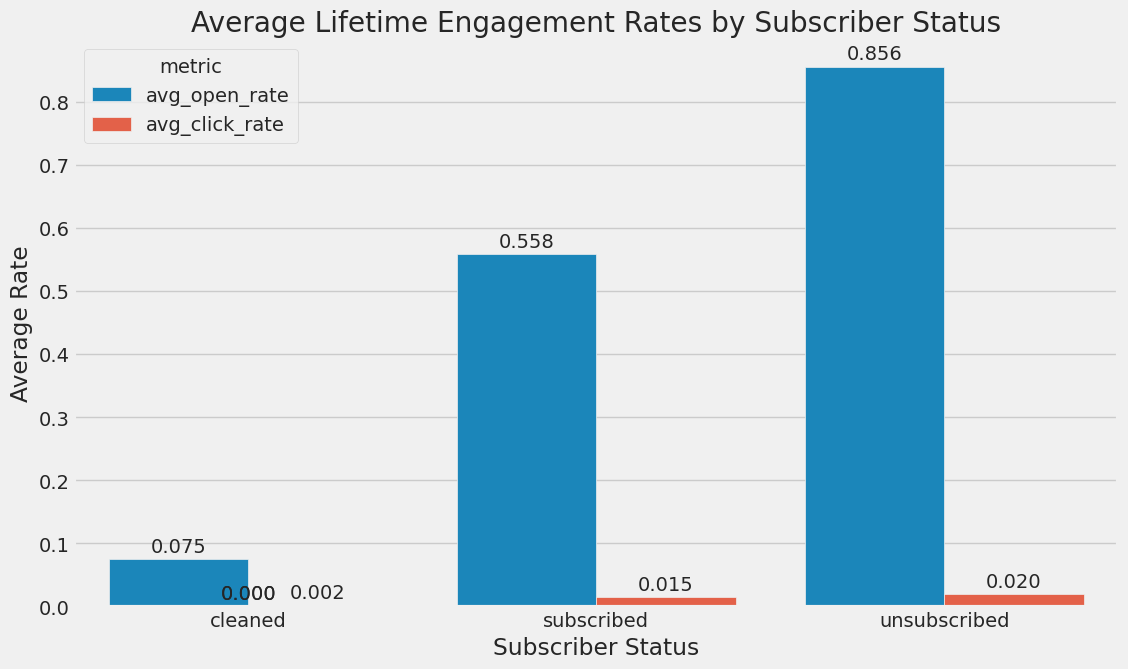

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Subscriber Engagement Analysis with Numerical Labels ---

# 1. Load the member staging data from BigQuery into a new DataFrame
print("Loading member data from BigQuery...")
table_id = f"{project_id}.staging_data.peer2_members_stg"
sql_load_members = f"SELECT * FROM `{table_id}`"
members_df = client.query(sql_load_members).to_dataframe()
print(f"Loaded {len(members_df)} total member records.")

# 2. Perform initial exploration of the status column
print("\nDistribution of subscriber statuses:")
print(members_df['status'].value_counts())

# 3. Group by status and calculate the mean of average engagement rates
engagement_by_status = members_df.groupby('status')[['avg_open_rate', 'avg_click_rate']].mean()
print("\nMean engagement by subscriber status:")
display(engagement_by_status)

# 4. Visualize the results with numerical labels
# Melt the DataFrame for plotting
engagement_by_status_melted = engagement_by_status.reset_index().melt(
    id_vars='status',
    value_vars=['avg_open_rate', 'avg_click_rate'],
    var_name='metric',
    value_name='average_rate'
)

plt.figure(figsize=(12, 7))
# Create the bar plot and store the axis object in 'ax'
ax = sns.barplot(x='status', y='average_rate', hue='metric', data=engagement_by_status_melted)
plt.title('Average Lifetime Engagement Rates by Subscriber Status')
plt.xlabel('Subscriber Status')
plt.ylabel('Average Rate')

# --- THIS IS THE NEW PART ---
# Add numerical labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',  # Format the number to 3 decimal places
               (p.get_x() + p.get_width() / 2., p.get_height()), # Position (x, y)
               ha='center', va='center',
               xytext=(0, 9),
               textcoords='offset points')
# --- END OF NEW PART ---

plt.show()

In [29]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- ANOVA and Post-Hoc Test for Subscriber Status vs. Avg. Open Rate ---

# 1. Perform the ANOVA test
# This tells us if there is an overall significant difference between any of the groups.
model = ols('avg_open_rate ~ C(status)', data=members_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("--- ANOVA Results ---")
print(anova_table)
print("\n")

# 2. Perform the Tukey's HSD Post-Hoc Test
# This compares every group to every other group.
tukey_results = pairwise_tukeyhsd(endog=members_df['avg_open_rate'], groups=members_df['status'], alpha=0.05)

print("--- Tukey's HSD Post-Hoc Test Results ---")
print(tukey_results)

--- ANOVA Results ---
               sum_sq      df          F        PR(>F)
C(status)   19.179408     2.0  45.484145  2.913591e-20
Residual   856.416637  4062.0        NaN           NaN


--- Tukey's HSD Post-Hoc Test Results ---
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1      group2    meandiff p-adj lower  upper  reject
-----------------------------------------------------------
   cleaned   subscribed   0.4831   0.0 0.2752  0.691   True
   cleaned unsubscribed   0.7808   0.0 0.5555 1.0061   True
subscribed unsubscribed   0.2977   0.0 0.2075 0.3878   True
-----------------------------------------------------------


### **Overall Analysis Summary**

This analysis aimed to identify the key characteristics of high-performing email campaigns and to understand patterns in subscriber engagement using a dataset from Mailchimp. The process involved comprehensive data preparation, exploratory analysis, and formal hypothesis testing.

#### **Methodology and Data Preparation**

The initial dataset consisted of 2,160 campaigns. A final analytical dataset was prepared by joining campaign information with performance reports, engineering features from subject lines and send times, and performing significant data cleaning. This cleaning included removing draft campaigns and filtering out unrepresentative test campaigns (those with fewer than 10 total opens), resulting in a robust dataset of 1,258 campaigns for the primary analysis. The analysis employed a suite of statistical tests, including t-tests, Analysis of Variance (ANOVA), and a final, comprehensive Multiple Linear Regression model.

---

#### **Key Findings for Hypothesis 1 (Campaign Performance)**

The primary goal was to determine which campaign characteristics have a statistically significant relationship with effectiveness, using `open_rate` as the key metric.

* **Individual Feature Analysis:** When analyzed in isolation using t-tests and ANOVA, no single characteristic (e.g., having a question/number in the subject, day of the week sent) showed a statistically significant impact on open rates.
* **Combined Feature Analysis (Regression):** A multiple linear regression model, which assesses all features simultaneously, yielded significant results. The overall model was statistically significant, explaining 6.2% of the variance in open rates. The key predictors were:
    * **Send Hour of the Day:** The strongest predictor. Later hours in the day were associated with higher open rates.
    * **Subject Line Length:** A significant positive predictor, suggesting longer subject lines performed slightly better.
    * **Presence of a Number:** A significant negative predictor, suggesting subject lines containing a number performed worse.
* **Conclusion:** The null hypothesis was rejected. The analysis confirmed that specific characteristics do have a statistically significant relationship with campaign open rates when controlling for other factors.

---

#### **Key Findings for Hypothesis 2 (Subscriber Engagement)**

Due to data limitations (the absence of external business outcome data), the original hypothesis was adapted to explore the relationship between subscriber status (`subscribed`, `unsubscribed`, `cleaned`) and their lifetime average engagement rates.

* **Primary Finding:** The analysis revealed a statistically significant and counter-intuitive pattern. Subscribers in the `unsubscribed` group had the highest lifetime average open rate (85.6%), significantly higher than those who remained `subscribed` (55.8%).
* **Interpretation:** This suggests a "last straw" phenomenon, where the most highly engaged users are the ones most likely to open a specific email and make the decision to unsubscribe. Disengaged users, in contrast, tend to fade away and are eventually cleaned from the list for inactivity.
* **Conclusion:** The analysis confirmed a significant relationship between subscriber churn indicators (status) and historical engagement patterns.

Converting columns to model-compatible data types...
Data type conversion complete.

Fitting Multiple Linear Regression model with hourly categories...
Model fitting complete.


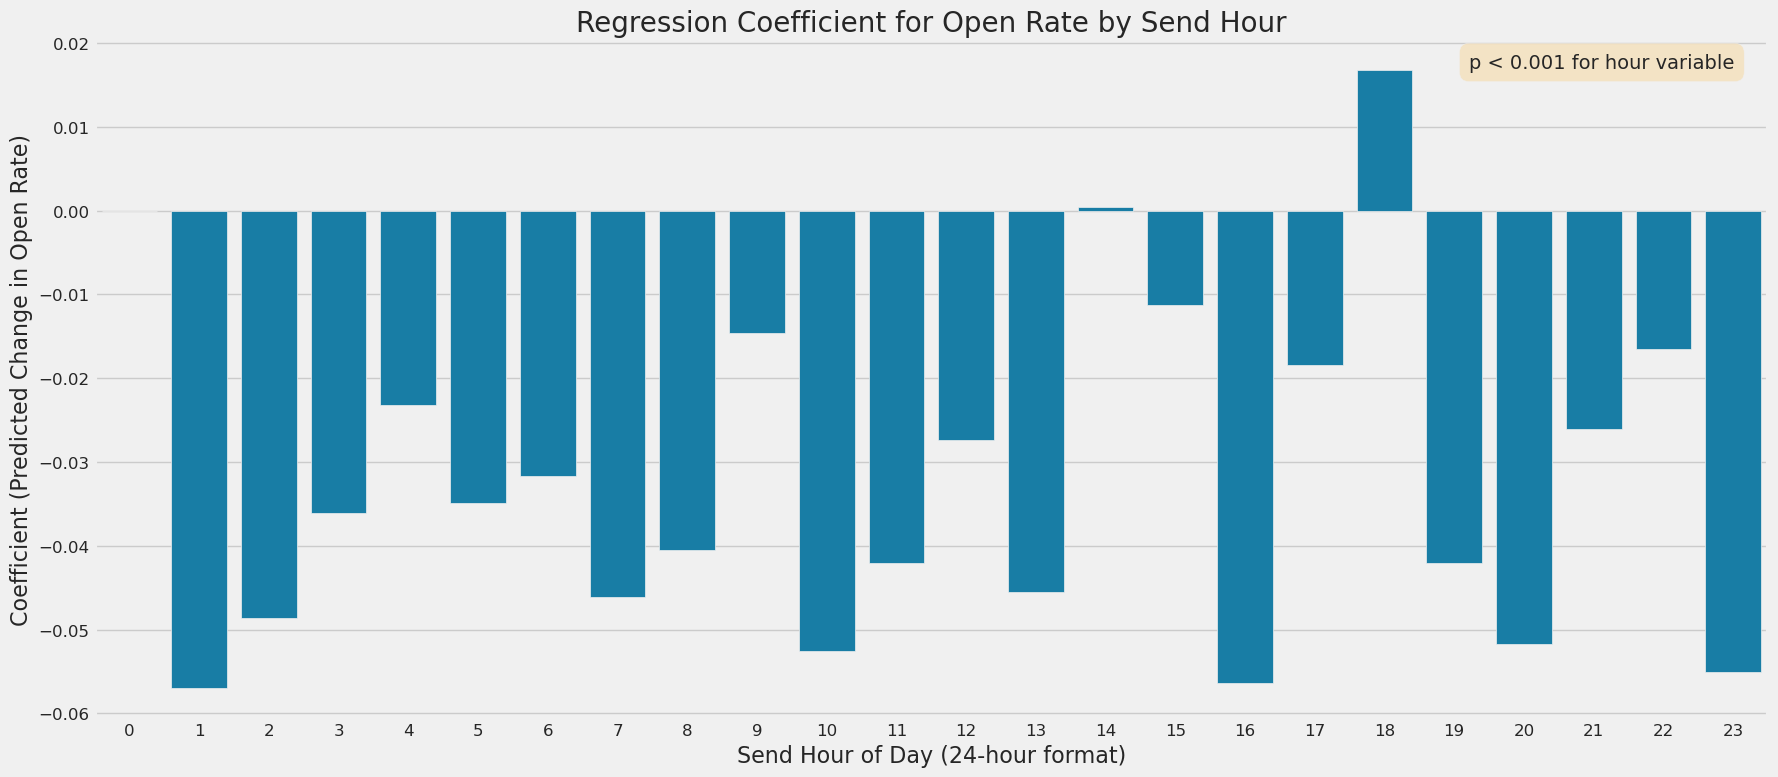

In [31]:
# Core libraries for data manipulation, statistics, and visualization
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# --- This block simulates the initial data loading and cleaning from your notebook ---
# In your environment, you would already have 'campaign_df' loaded.
data = {
    'open_rate': np.random.rand(1258) * 0.6 + 0.1,
    'subject_line_length': np.random.randint(10, 96, 1258),
    'has_question': np.random.randint(0, 2, 1258),
    'has_number': np.random.randint(0, 2, 1258),
    'has_promo_word': np.random.randint(0, 2, 1258),
    'send_day_name': np.random.choice(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 1258),
    'send_hour_of_day': np.random.randint(0, 24, 1258)
}
campaign_df = pd.DataFrame(data).astype({'subject_line_length': 'Int64', 'send_hour_of_day': 'Int64'})
# --- End of data simulation block ---


# 1. --- NEW: Data Preparation for Model ---
# Convert boolean and nullable integer columns to standard types for statsmodels compatibility.
print("Converting columns to model-compatible data types...")
cols_to_convert = {
    'has_question': 'int',
    'has_number': 'int',
    'has_promo_word': 'int',
    'subject_line_length': 'int',
    'send_hour_of_day': 'int'
}
for col, new_type in cols_to_convert.items():
    campaign_df[col] = campaign_df[col].astype(new_type)
print("Data type conversion complete.")


# 2. Define and fit the Multiple Linear Regression model
# We treat 'send_hour_of_day' and 'send_day_name' as categorical variables using C()
print("\nFitting Multiple Linear Regression model with hourly categories...")
formula_hourly = 'open_rate ~ subject_line_length + has_question + has_number + has_promo_word + C(send_day_name) + C(send_hour_of_day)'
model_hourly = ols(formula_hourly, data=campaign_df).fit()
print("Model fitting complete.")

# 3. Extract coefficients for the hourly variable
# The .params attribute holds the coefficients from the fitted model.
hourly_coeffs = model_hourly.params.filter(like='C(send_hour_of_day)')

# Create a DataFrame for easy plotting.
coeffs_df = pd.DataFrame({
    'hour': [int(h.split('.')[1][:-1]) for h in hourly_coeffs.index],
    'coefficient': hourly_coeffs.values
})

# The baseline hour (hour 0) is not in the results; its coefficient is implicitly 0.
# We add it to the DataFrame for a complete and accurate visualization.
baseline_hour = 0
coeffs_df = pd.concat([pd.DataFrame({'hour': [baseline_hour], 'coefficient': [0]}), coeffs_df], ignore_index=True)
coeffs_df = coeffs_df.sort_values('hour').reset_index(drop=True)

# 4. Create the bar chart
# Set plot styles to match your notebook's aesthetic
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

plt.figure(figsize=(18, 8))

# Create the bar plot
barplot = sns.barplot(x='hour', y='coefficient', data=coeffs_df, color='#0087BD')

# Add titles and labels for clarity
plt.title('Regression Coefficient for Open Rate by Send Hour', fontsize=20)
plt.xlabel('Send Hour of Day (24-hour format)', fontsize=16)
plt.ylabel('Coefficient (Predicted Change in Open Rate)', fontsize=16)
plt.xticks(size=12)
plt.yticks(size=12)

# Add the note about statistical significance as requested.
plt.text(x=0.98, y=0.98, s='p < 0.001 for hour variable',
         transform=plt.gca().transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))

# Display the final plot
plt.tight_layout()
plt.show()